In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import linecache
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle

In [2]:
# initialize mode params
num_mode=3
ny=161
nz=23
y=np.zeros((ny,1))
z=np.zeros((nz,1))
data1=np.zeros((ny,nz))
data2=np.zeros((ny,nz))
mode_data=[['' for i in range(3)] for j in range(1)]

In [3]:
# get mode1-3 E and H data
j=0
for i in range(3+1,3+1+ny):
    y[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

j=0
for i in range(3+ny+2+1,3+ny+2+1+nz):
    z[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

for k in range(num_mode):
    j=0
    for i in range(3+ny+2+nz+2+1,3+ny+2+nz+2+1+ny):
        data1[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode'+str(k+1)+'_ey.txt', i).split()
        j+=1  
    mode_data[0][k]=np.copy(data1.T)

# Normlize integral{|E|^2*dydz} to 1
dy=(y[-1,0]-y[0,0])/(y.shape[0]-1)
dz=(z[-1,0]-z[0,0])/(z.shape[0]-1)
norm_mode=np.zeros((1,num_mode))
for i in range(num_mode):
    norm_mode[0,i]=np.sum(mode_data[0][i]**2*dy*dz)
    mode_data[0][i]/=np.sqrt(norm_mode[0,i])

In [4]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[n_y,None])
    return X, Y

In [5]:
def initialize_parameters(parameters=None):
    if parameters==None:
        tf.set_random_seed(2)      
        W1 = tf.get_variable("W1", [25,19], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
        b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [3,12], initializer = tf.contrib.layers.xavier_initializer(seed = 5))
        b3 = tf.get_variable("b3", [3,1], initializer = tf.zeros_initializer())
    else:
        W1 = tf.get_variable("W1",  initializer = tf.constant(parameters['W1']))
        b1 = tf.get_variable("b1",  initializer = tf.constant(parameters['b1']))
        W2 = tf.get_variable("W2",  initializer = tf.constant(parameters['W2']))
        b2 = tf.get_variable("b2",  initializer = tf.constant(parameters['b2']))
        W3 = tf.get_variable("W3",  initializer = tf.constant(parameters['W3']))
        b3 = tf.get_variable("b3",  initializer = tf.constant(parameters['b3']))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [6]:
def forward_propagation(X, parameters):   
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1,X) + b1                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.tanh(Z1)                                              # A1 = tanh(Z1)
    Z2 = tf.matmul(W2,A1) + b2                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.tanh(Z2)                                              # A2 = tanh(Z2)
    Z3 = tf.matmul(W3,A2) + b3                                              # Z3 = np.dot(W3,Z2) + b3
   
    return Z3

In [7]:
def compute_cost2(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum((Y-A3)**2,axis=1))
    
    return tf.transpose(A3),cost

In [8]:
def model_check(X_test, Y_test, parameters = None, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, _) = X_test.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_test.shape[0]                            # n_y : output size
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    A3,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        [A3_test,cost2_test]=sess.run([A3, cost2], feed_dict={X: X_test, Y: Y_test})
    if print_cost==True:
        print("Test mean square error: {:.2e}.".format(cost2_test))
        
        
        return A3_test,cost2_test

In [9]:
f = open('parameters_min_cost_test.data', 'rb')
parameters,_,_ = pickle.load(f)
f.close()

In [10]:
num_data_set=100
m_all=100 # number of all the samples
pert=0.05 # perturbation of intensity after field's superposition
A3_test=np.zeros((num_data_set,3,m_all))
cost_test=np.zeros((num_data_set,1))
Y_test_set=np.zeros((num_data_set,3,m_all))
mode_comp_set=[''for i in range(num_data_set)]

In [11]:
for i_data_set in range(num_data_set):
    # Synthesis data set
    field_sp=[[0 for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
    np.random.seed(None) # random seed(0)
    rd1=np.random.rand(3,m_all)
    np.random.seed(None) # random seed(1)
    rd2=np.random.rand(3,m_all)
    mode_comp=rd1*np.exp(1j*rd2*2*np.pi)
    mode_comp_set[i_data_set]=np.copy(mode_comp)
    mode_comp_label=rd1**2/np.sum(rd1**2,axis=0)
    for i in range(m_all):
        for j in range(num_mode):
            field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
    
    # get farfield diffraction pattern
    sp_y=y.shape[0] # sampling points along y
    sp_z=z.shape[0] # sampling points along z
    ff_data=[]
    for i in range(m_all):
        ff_data.append(np.fft.fftshift(np.fft.fft2(field_sp[0][i]))/sp_y/sp_z)
    
    ff_i_data_x=['' for i in range(m_all)]
    for i in range(m_all):
        ff_i_data_x[i]=np.sum(np.abs(ff_data[i])**2,axis=0,keepdims=True)
        
    ff_i_data_x=np.array(ff_i_data_x).squeeze().T
    ff_i_data_x=ff_i_data_x[71:90,:]
    ff_i_data_x.shape
    
    X_test=np.log10(ff_i_data_x)
    Y_test=mode_comp_label
    Y_test_set[i_data_set,:,:]=Y_test
    [A3_test[i_data_set,:,:],cost_test[i_data_set,0]]=model_check(X_test, Y_test, parameters = parameters, print_cost = True)

Test mean square error: 1.59e-03.
Test mean square error: 1.70e-03.
Test mean square error: 1.85e-03.
Test mean square error: 1.77e-03.
Test mean square error: 1.13e-03.
Test mean square error: 1.32e-03.
Test mean square error: 1.26e-03.
Test mean square error: 1.25e-03.
Test mean square error: 1.85e-03.
Test mean square error: 1.58e-03.
Test mean square error: 1.16e-03.
Test mean square error: 1.44e-03.
Test mean square error: 1.58e-03.
Test mean square error: 1.65e-03.
Test mean square error: 1.39e-03.
Test mean square error: 1.69e-03.
Test mean square error: 1.64e-03.
Test mean square error: 1.91e-03.
Test mean square error: 1.41e-03.
Test mean square error: 1.27e-03.
Test mean square error: 1.26e-03.
Test mean square error: 1.35e-03.
Test mean square error: 2.44e-03.
Test mean square error: 2.41e-03.
Test mean square error: 1.24e-03.
Test mean square error: 1.39e-03.
Test mean square error: 1.42e-03.
Test mean square error: 1.25e-03.
Test mean square error: 1.44e-03.
Test mean squa

In [12]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = '{:.4}'.format(100 * y/num_data_set)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

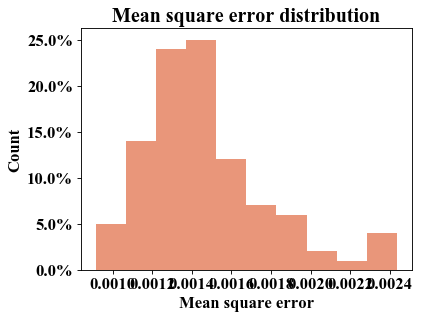

In [13]:
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 15}

plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
plt.title('Mean square error distribution', **font_suptitle)
plt.xlabel('Mean square error', **font_label)
plt.ylabel('Count', **font_label)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
plt.hist(cost_test,color='darksalmon')
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [14]:
max_error_index=np.argsort(np.squeeze(cost_test))[-1:-11:-1]
print(max_error_index)
print(cost_test[max_error_index,0])

[5 8 7 6 9 2 4 0 3 1]
[ 0.00209663  0.00176901  0.00157352  0.00156724  0.00151576  0.00142947
  0.00138222  0.00134259  0.00127165  0.00115146]


[20 93 37 40 79 56 34 44 92 76]


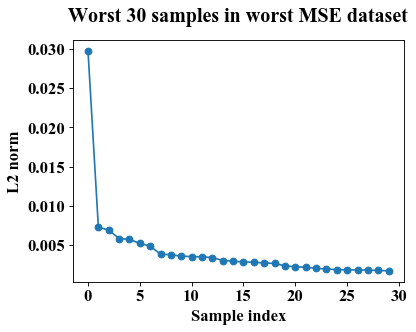

index_20:
[ 0.33575525  0.6144656   0.04977915] [ 0.20844543  0.73021072  0.06134392]


In [15]:
dsi=3
si = 0
worst_dataset=np.sum(np.abs(A3_test[max_error_index[dsi],:,:]-Y_test_set[max_error_index[dsi],:,:])**2,axis=0)
sar=np.argsort(worst_dataset)[-1:-11:-1] # sorted array
print(sar)
plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 15}
plt.plot(np.sort(worst_dataset)[-30:][::-1],'o-')
plt.title('Worst 30 samples in worst MSE dataset',**font_suptitle,y=1.05)
plt.xlabel('Sample index',**font_label)
plt.ylabel('L2 norm',**font_label)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
plt.show()

np.random.seed(None)
print("index_{}:".format(sar[si]))
print(Y_test_set[max_error_index[dsi],:,:].T[sar[si],:],A3_test[max_error_index[dsi],:,:].T[sar[si],:])

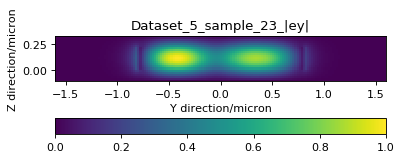

Amplitude label: 
[ 44.01826935  50.40453444   5.57719621]
Amplitude prediction: 
[ 24.13755953  66.15033746   9.71209928]
Phase: 
[ -28.02846251 -119.22554488  -69.10115717]


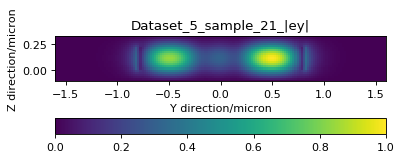

Amplitude label: 
[ 15.36159402  25.76361158  58.8747944 ]
Amplitude prediction: 
[  6.7289561   25.45883656  67.8121984 ]
Phase: 
[  47.7462018   153.16708612   51.41688082]


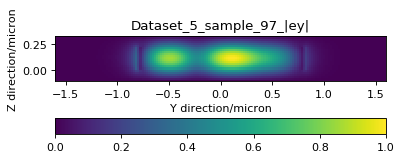

Amplitude label: 
[ 15.09335605  54.18917437  30.71746958]
Amplitude prediction: 
[  7.96301812  60.63268185  31.40429258]
Phase: 
[ 92.95079574 -33.70646527 -93.40122631]


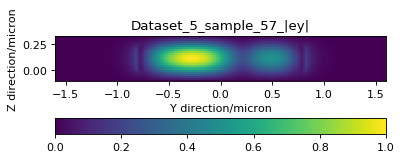

Amplitude label: 
[ 45.51211632  50.1811844    4.30669928]
Amplitude prediction: 
[ 39.63251114  54.74475026   5.62273301]
Phase: 
[ 104.57314804   72.80346793 -155.51598412]


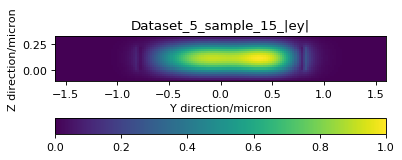

Amplitude label: 
[ 49.62520772  45.61075073   4.76404155]
Amplitude prediction: 
[ 44.01457906  50.55639148   5.42902723]
Phase: 
[-117.03538439  -18.64796452  115.76318632]


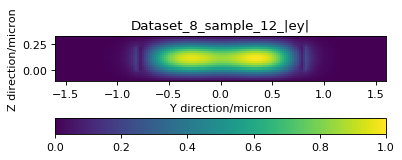

Amplitude label: 
[ 48.50571825  50.99673695   0.49754479]
Amplitude prediction: 
[ 32.91312754  65.61209559   1.47477733]
Phase: 
[   2.97071447  -88.08914321  150.57351647]


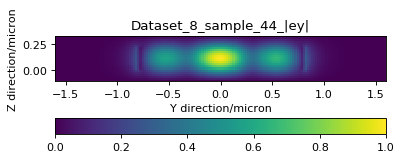

Amplitude label: 
[ 14.95852808  22.66657033  62.37490159]
Amplitude prediction: 
[  5.1524777   27.28207111  67.56545305]
Phase: 
[ 137.47756026   58.28396615  -40.39326655]


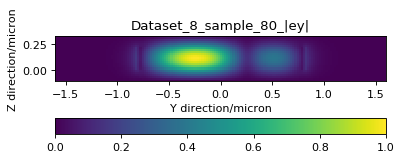

Amplitude label: 
[ 48.45316342  47.98092797   3.56590861]
Amplitude prediction: 
[ 41.34241641  54.94798422   3.70960273]
Phase: 
[ 154.31553851  138.21652502  -71.00526433]


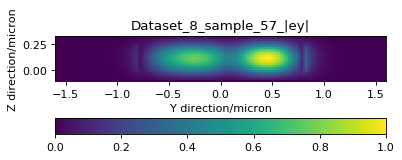

Amplitude label: 
[ 36.89423745  53.21250539   9.89325716]
Amplitude prediction: 
[ 29.61451411  58.95749331  11.4279829 ]
Phase: 
[ 159.70357273   70.70071591 -134.7048657 ]


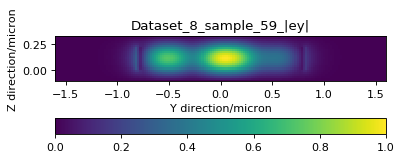

Amplitude label: 
[ 21.640938    33.33947486  45.01958714]
Amplitude prediction: 
[ 14.53023702  34.78185833  50.68790913]
Phase: 
[  22.10123942  131.31551378 -168.58454847]


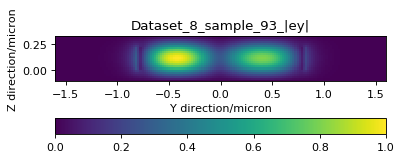

Amplitude label: 
[ 33.58022402  56.75698569   9.66279029]
Amplitude prediction: 
[ 27.19189823  62.98758984   9.82050896]
Phase: 
[  32.672167    116.05906637   47.82687713]


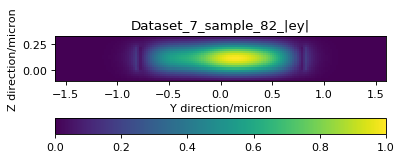

Amplitude label: 
[ 46.65246321  46.03119809   7.3163387 ]
Amplitude prediction: 
[ 36.07667387  55.5231154    8.40020478]
Phase: 
[ 168.90070805  -81.42045871   -2.25680014]


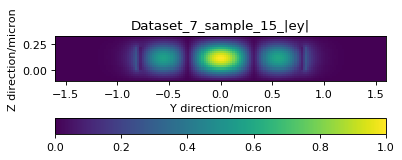

Amplitude label: 
[ 13.8583931    0.69499059  85.44661631]
Amplitude prediction: 
[  4.5437865   11.01337448  84.44283605]
Phase: 
[-165.58574478  -85.16468868   16.29845829]


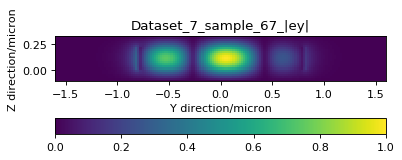

Amplitude label: 
[ 18.20716902  14.23188991  67.56094107]
Amplitude prediction: 
[ 10.58805212  17.73037761  71.68157101]
Phase: 
[-122.88754842   37.70052734   41.13966791]


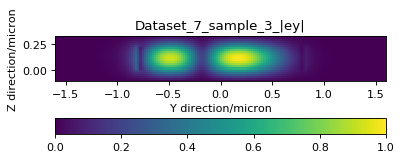

Amplitude label: 
[ 12.72734088  65.35859281  21.91406632]
Amplitude prediction: 
[  5.91791049  70.26379704  23.81828725]
Phase: 
[ -79.1649562   124.17897559  101.62015099]


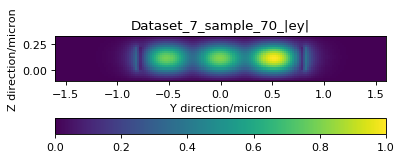

Amplitude label: 
[  0.68068784  26.69539658  72.62391559]
Amplitude prediction: 
[  4.58821394  29.01306748  66.39871597]
Phase: 
[  70.65222875 -136.31949017  -33.13135046]


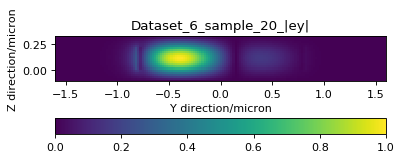

Amplitude label: 
[ 33.57552477  61.44656024   4.97791499]
Amplitude prediction: 
[ 20.84454298  73.02107215   6.13439195]
Phase: 
[ 91.07780005  88.05908431  96.33245971]


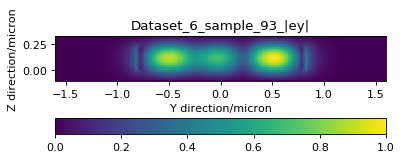

Amplitude label: 
[  2.15881959  31.78001725  66.06116316]
Amplitude prediction: 
[  5.36083654  35.53854823  59.10061002]
Phase: 
[-110.80758523 -159.53509818  -58.43651558]


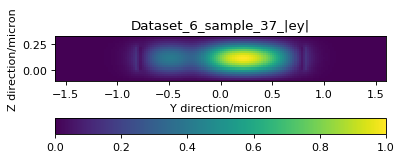

Amplitude label: 
[ 49.03501662  46.07203123   4.89295214]
Amplitude prediction: 
[ 43.02159548  51.80587769   5.17253093]
Phase: 
[ -23.15776767  120.19267417  165.98237876]


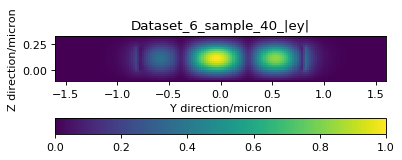

Amplitude label: 
[ 11.1227687   14.50324638  74.37398492]
Amplitude prediction: 
[  4.92166542  17.02831984  78.05001736]
Phase: 
[ -89.10062811  -52.65725719  102.7079894 ]


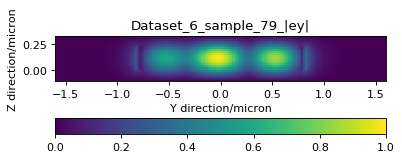

Amplitude label: 
[  7.8152951   26.98639667  65.19830823]
Amplitude prediction: 
[  2.98542455  32.74166882  64.2729044 ]
Phase: 
[  -9.54790155  -72.78040521  174.21564241]


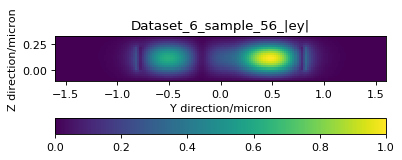

Amplitude label: 
[ 35.69851324  14.14216989  50.15931686]
Amplitude prediction: 
[ 30.1335156   15.23634642  54.63013649]
Phase: 
[-98.92003098  55.35862584 -68.59333876]


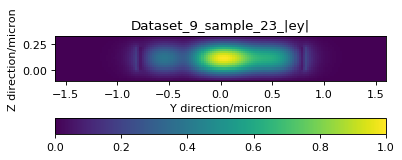

Amplitude label: 
[ 36.65906255  29.35925165  33.9816858 ]
Amplitude prediction: 
[ 45.32575607  26.94906592  27.725178  ]
Phase: 
[ 107.54151339  -10.0658896  -100.25268702]


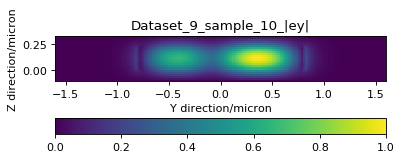

Amplitude label: 
[  2.50721663e+01   7.49107984e+01   1.70353075e-02]
Amplitude prediction: 
[ 31.89633191  67.23585725   0.86781103]
Phase: 
[ 31.00130479 -93.74144703 -98.20587602]


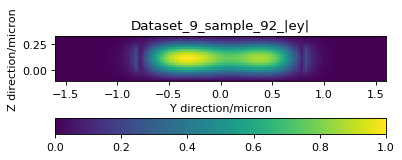

Amplitude label: 
[ 26.26510197  69.02078583   4.7141122 ]
Amplitude prediction: 
[ 19.65847462  76.66612864   3.67539153]
Phase: 
[-143.61231455  136.70413818   41.22583007]


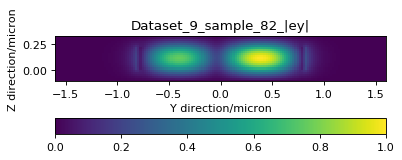

Amplitude label: 
[ 10.55826666  89.337543     0.10419034]
Amplitude prediction: 
[ 17.20164567  81.74177408   1.05658509]
Phase: 
[ 172.95035572   49.83202138  162.17897294]


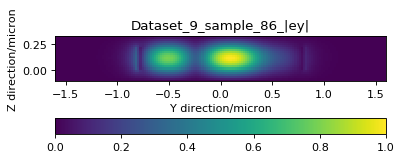

Amplitude label: 
[ 20.22016631  40.31246502  39.46736867]
Amplitude prediction: 
[ 13.38985413  44.49071288  42.11944044]
Phase: 
[ 103.47307531  -35.3780681   -70.89640993]


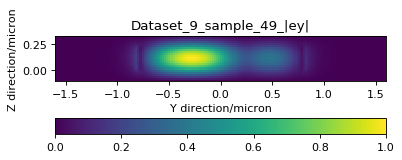

Amplitude label: 
[ 48.02011492  51.25551111   0.72437397]
Amplitude prediction: 
[ 54.02329564  45.60737312   0.36933413]
Phase: 
[ 65.84917161  96.57764046 -91.94756915]


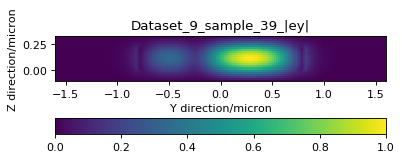

Amplitude label: 
[ 48.75655673  50.37642161   0.86702167]
Amplitude prediction: 
[ 54.5953691   45.04514635   0.35948488]
Phase: 
[ -17.972336    142.6678015   140.08158692]


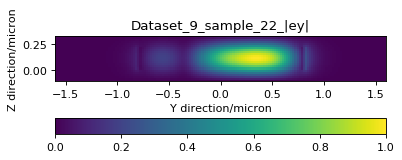

Amplitude label: 
[ 61.07643405  27.6803484   11.24321755]
Amplitude prediction: 
[ 67.28173494  23.91675115   8.80151689]
Phase: 
[  32.29425889 -133.50729014  120.05169253]


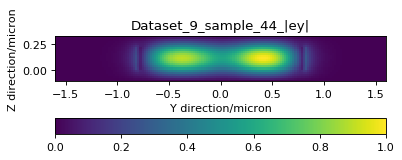

Amplitude label: 
[ 67.08205181  25.28887386   7.62907433]
Amplitude prediction: 
[ 61.51617765  30.24392128   8.23990479]
Phase: 
[-65.19759156  27.77527487 -80.29183586]


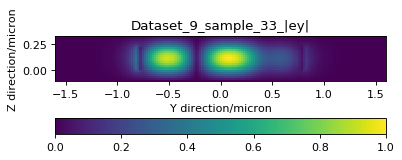

Amplitude label: 
[ 10.42730428  30.68469028  58.88800543]
Amplitude prediction: 
[  4.77785803  34.94020104  60.28195024]
Phase: 
[-164.5291629    18.42819696   -6.29945867]


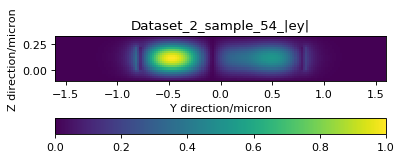

Amplitude label: 
[ 18.93457777  38.03743805  43.02798418]
Amplitude prediction: 
[  7.51877278  48.11597764  44.36524808]
Phase: 
[-55.62089993  10.18471241 -37.24262266]


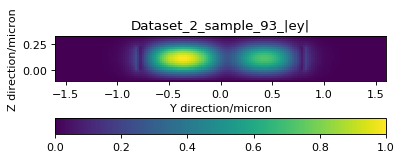

Amplitude label: 
[  1.44247392e+01   8.55491521e+01   2.61086587e-02]
Amplitude prediction: 
[ 22.30746299  76.75869465   0.93384096]
Phase: 
[-179.86637762  126.38448659 -117.28029416]


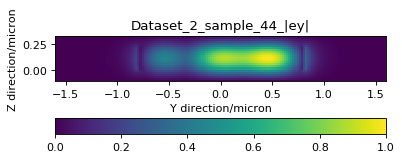

Amplitude label: 
[ 21.54835496  44.78890676  33.66273828]
Amplitude prediction: 
[ 14.51136321  50.65120459  34.83743072]
Phase: 
[-142.68744412   86.17078755  -20.43057423]


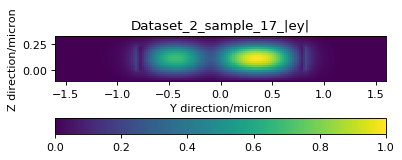

Amplitude label: 
[ 28.64441819  69.26578681   2.089795  ]
Amplitude prediction: 
[ 22.8802219   73.66933227   3.45044844]
Phase: 
[ -68.51940152  163.67762796 -131.78762118]


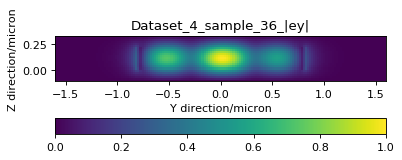

Amplitude label: 
[ 12.77328555  24.38762206  62.83909239]
Amplitude prediction: 
[  4.92967218  30.28490543  64.78542089]
Phase: 
[-163.10679909  100.42292285   24.09390682]


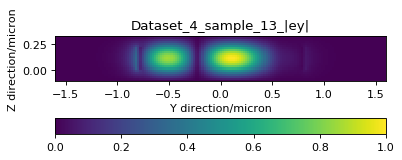

Amplitude label: 
[ 16.97868184  40.97392282  42.04739534]
Amplitude prediction: 
[  9.36969519  44.11229789  46.51800096]
Phase: 
[  66.31738581 -124.85919181 -130.06923461]


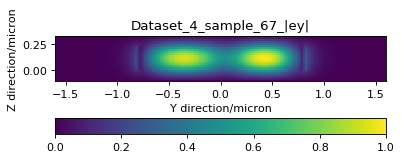

Amplitude label: 
[ 44.78809514  50.32630431   4.88560055]
Amplitude prediction: 
[ 38.66275549  53.72039676   7.61684179]
Phase: 
[-12.81774262  73.63058811 -44.26634466]


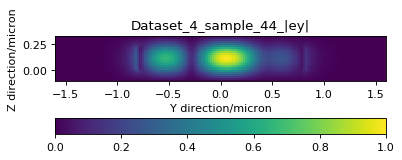

Amplitude label: 
[ 23.71667636  18.8360317   57.44729194]
Amplitude prediction: 
[ 19.73715574  17.00091511  63.26192617]
Phase: 
[ 134.73527404  -71.86087319  -37.26011792]


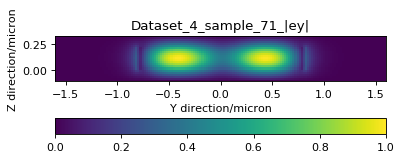

Amplitude label: 
[ 55.46911194  31.63326762  12.89762044]
Amplitude prediction: 
[ 50.9827137   37.24334538  11.77394018]
Phase: 
[ 34.62566358 -52.63796336  41.33190258]


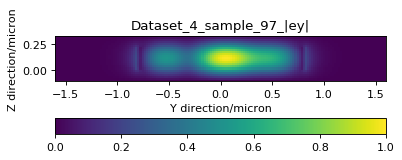

Amplitude label: 
[ 28.7560196  36.8334005  34.4105799]
Amplitude prediction: 
[ 34.30588245  35.85821092  29.83590364]
Phase: 
[ 168.58619975   46.1699225   -35.61125634]


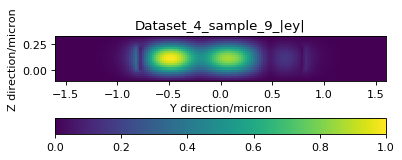

Amplitude label: 
[ 24.10303277  32.24518078  43.65178644]
Amplitude prediction: 
[ 29.88926172  29.75967824  40.35106003]
Phase: 
[ 28.1729606  -58.93684997 -80.89111025]


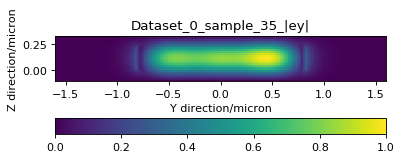

Amplitude label: 
[ 11.45447193  68.27817023  20.26735784]
Amplitude prediction: 
[  2.93602049  78.3646822   18.69928986]
Phase: 
[ 162.44148791   60.96487245  -35.61052708]


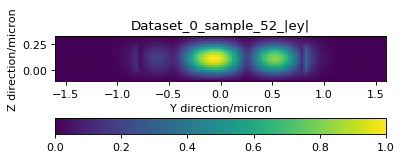

Amplitude label: 
[ 16.75640133  26.78544528  56.45815338]
Amplitude prediction: 
[  8.54866877  28.12613249  63.3251965 ]
Phase: 
[-164.69504902 -130.34227133   27.42889609]


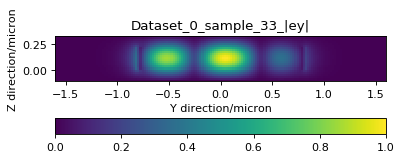

Amplitude label: 
[ 15.02441522  12.56347174  72.41211304]
Amplitude prediction: 
[  8.9121066   11.85865924  79.22922969]
Phase: 
[-126.66404279  102.67389935   94.88251858]


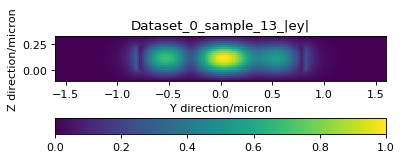

Amplitude label: 
[ 14.61879885  22.09870488  63.28249627]
Amplitude prediction: 
[  7.34174699  25.35804808  67.30020046]
Phase: 
[-111.08480072  124.41695997   53.26395148]


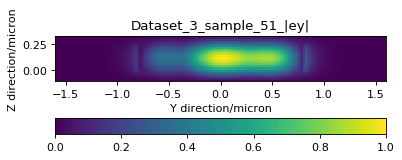

Amplitude label: 
[ 31.20950035  39.85502886  28.93547079]
Amplitude prediction: 
[ 21.59716785  48.59970212  29.80313301]
Phase: 
[ -82.52929835  162.938303     58.3171533 ]


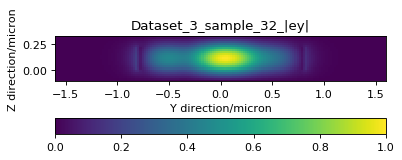

Amplitude label: 
[ 44.57775565  29.51573506  25.90650929]
Amplitude prediction: 
[ 51.94324851  27.42184401  20.63490301]
Phase: 
[-169.69038141   81.37978556    9.8983691 ]


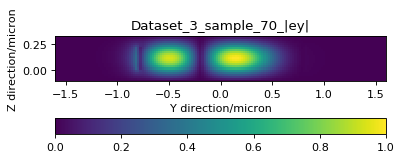

Amplitude label: 
[ 12.69526501  57.49308743  29.81164756]
Amplitude prediction: 
[  5.84861338  60.90891361  33.24247003]
Phase: 
[-144.01084601   45.44573206   39.70150131]


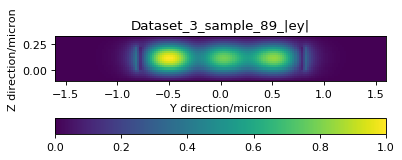

Amplitude label: 
[  0.16975205  39.77894778  60.05130017]
Amplitude prediction: 
[  3.78836133  42.82257259  53.3890605 ]
Phase: 
[ -10.47018056  124.79353733 -156.55780974]


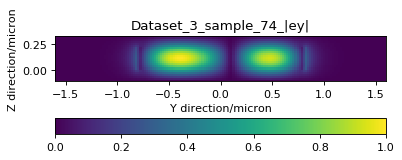

Amplitude label: 
[ 19.24379419  62.10006957  18.65613624]
Amplitude prediction: 
[ 15.13503194  67.70892143  17.15604812]
Phase: 
[ 178.89399767 -119.71592911  135.29685604]


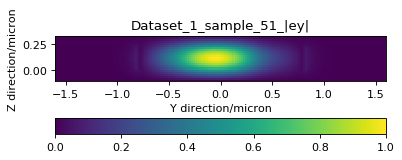

Amplitude label: 
[ 82.69465198  10.34144297   6.96390506]
Amplitude prediction: 
[ 74.05934334  14.58441019  11.35623753]
Phase: 
[-104.07287704  -45.19389108   73.35736049]


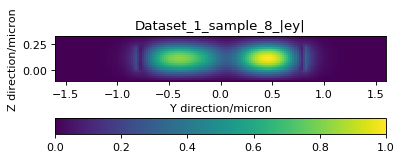

Amplitude label: 
[ 46.19152006  35.34360409  18.46487585]
Amplitude prediction: 
[ 41.00662768  41.34394526  17.64943004]
Phase: 
[-146.79214586  124.26987453 -118.62293786]


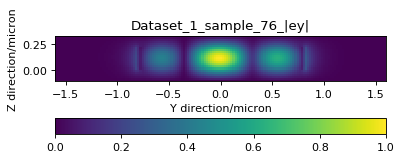

Amplitude label: 
[ 19.7269646    2.81163212  77.46140327]
Amplitude prediction: 
[ 13.23220879   5.74873686  81.01905584]
Phase: 
[-131.23040672 -179.49849929   26.03735379]


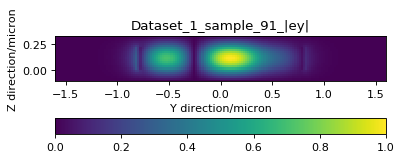

Amplitude label: 
[ 26.98599271  30.06134885  42.95265845]
Amplitude prediction: 
[ 21.1695075   32.59010613  46.24038041]
Phase: 
[ 104.34876713  -69.87032621  -40.59728825]


In [20]:
training_data_add=[]
dsi=0
si=0
yy,zz=np.meshgrid(y,z)
for dsi in range(10):
    for si in range(10):
        worst_dataset=np.sum(np.abs(A3_test[max_error_index[dsi],:,:]-Y_test_set[max_error_index[dsi],:,:])**2,axis=0)
        sar=np.argsort(worst_dataset)[-1:-11:-1] # sorted array
        if worst_dataset[sar[si]]>=5e-3:
            temp=mode_comp_set[max_error_index[dsi]][:,sar[si]]
            training_data_add.append(np.copy(temp))

            # Synthesis data set
            field_sp_inspect=np.zeros((23,161),dtype=np.complex)
            for i in range(num_mode):
                field_sp_inspect+=np.multiply(temp[i],mode_data[0][i])

            # view specified sample
            plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
            plt.title('Dataset_{}_sample_{}_|ey|'.format(max_error_index[dsi],sar[si]))
            plt.pcolormesh(yy,zz,np.abs(field_sp_inspect)/np.max(np.abs(field_sp_inspect)))
            plt.xlabel("Y direction/micron")
            plt.ylabel("Z direction/micron")
            plt.ylim(-0.11, 0.33)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.colorbar(orientation='horizontal')
            plt.show()
            print("Amplitude label: ")
            print(100*Y_test_set[max_error_index[dsi],:,sar[si]])
            print("Amplitude prediction: ")
            print(100*A3_test[max_error_index[dsi],:,sar[si]])
            print("Phase: ")      
            print(np.angle(temp,deg=True))


In [21]:
# save training_data_add
f = open('training_data_add_1_102417.data', 'wb')
pickle.dump(training_data_add, f)
f.close()

In [22]:
len(training_data_add)

56

In [ ]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = '{:.4}'.format(100 * y/m_all)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

In [ ]:
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')

font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 12}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 12}

plt.suptitle('Absolute deviation distribution of worst MSE dataset',x=0.5,y=1.05,**font_suptitle)

plt.subplot(1,3,1)
plt.hist(np.abs(A3_test[max_error_index,0,:]-Y_test_set[max_error_index,0,:]),bins=12,range=(0,0.12))
plt.title('Mode 0',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1,3,2)
plt.hist(np.abs(A3_test[max_error_index,1,:]-Y_test_set[max_error_index,1,:]),bins=12,range=(0,0.12))
plt.title('Mode 1',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1,3,3)
plt.hist(np.abs(A3_test[max_error_index,2,:]-Y_test_set[max_error_index,2,:]),bins=12,range=(0,0.12))
plt.title('Mode 2',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()